<a href="https://colab.research.google.com/github/Mercymerine/Machine_learning2/blob/main/Brain_tumors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Getting the datasets**

In [1]:
import pathlib
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

In [2]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 73% 11.0M/15.1M [00:00<00:00, 55.0MB/s]
100% 15.1M/15.1M [00:00<00:00, 68.5MB/s]


In [3]:
input_dir = pathlib.Path('/content/brain-mri-images-for-brain-tumor-detection.zip')

In [4]:
#Unzipping the dataset
zip_ref = zipfile.ZipFile('brain-mri-images-for-brain-tumor-detection.zip', 'r')
zip_ref.extractall()
zip_ref.close()

Lists image files: It uses os.listdir() to grab the filenames of the first 5 images in the specified folder (image_folder).

Opens each image: It opens each image file using PIL (Python Imaging Library), which allows you to load and work with images in Python.

Displays each image: It then uses matplotlib, a popular plotting library, to display the images one by one in a popup window or inline (if you are using a Jupyter Notebook).

In [5]:
!ls brain_tumor_dataset

no  yes


## **Viewing Images**

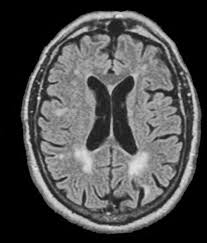

In [6]:
#Viewing each image sample actual picture
from PIL import Image
Image.open('brain_tumor_dataset/no/22 no.jpg')

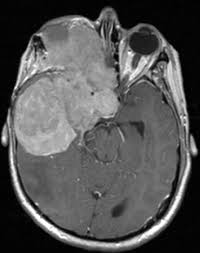

In [7]:
import os
os.listdir('brain_tumor_dataset/yes')

from PIL import Image
Image.open('/content/brain_tumor_dataset/yes/Y106.jpg')

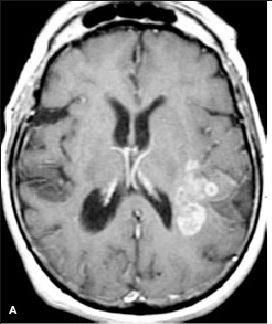

In [8]:
from PIL import Image
Image.open('/content/brain_tumor_dataset/yes/Y111.JPG')

## **Getting the class names**

In [9]:
data_dir = pathlib.Path('/content/brain_tumor_dataset')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['no' 'yes']


## **Splitting the dataset using os and shutil**

In [10]:
import shutil
from sklearn.model_selection import train_test_split

In [11]:
#Define the source directory containing images and destination directories
source_dir = '/content/brain_tumor_dataset'
train_dir = 'content/train'
val_dir = 'content/val'
test_dir = 'content/test'

#Create train, validation and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#Iterate through each class folder
for class_folder in os.listdir(source_dir):
  class_path = os.path.join(source_dir, class_folder)

  #Check if the current item is a directory class
  if os.path.isdir(class_path):

    #List all images for this class
    images = os.listdir(class_path)

    #Split images into train, validation and test datasets
    train_images, test_images = train_test_split(images, test_size = 0.2, random_state=42)
    val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

    #Create subdirectories for this class in train, val and test folders
    os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

    #Copy the images to the respective directories
    for image in train_images:
      shutil.copy(os.path.join(class_path, image), os.path.join(train_dir, class_folder, image))
    for image in val_images:
      shutil.copy(os.path.join(class_path, image), os.path.join(val_dir, class_folder, image))
    for image in test_images:
      shutil.copy(os.path.join(class_path, image), os.path.join(test_dir, class_folder, image))

## **Load the data with ImageDataGenerator**

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
#Rescaling the data and applying augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                rotation_range = 40,
                                width_shift_range =0.2,
                                height_shift_range =0.2,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip =True,
                                validation_split = 0.2)

In [14]:
#Loading the training data
train_data = train_datagen.flow_from_directory('/content/brain_tumor_dataset',
                                               target_size = (256, 256),
                                               batch_size = 32,
                                               class_mode = 'categorical',
                                               subset = 'training')

Found 203 images belonging to 2 classes.


In [15]:
#Loading the validation data
validation_data = train_datagen.flow_from_directory('/content/brain_tumor_dataset',
                                                    target_size = (256, 256),
                                                    batch_size =32,
                                                    class_mode = 'categorical',
                                                    subset = 'validation')

Found 50 images belonging to 2 classes.


## **BUILD THE CNN MODEL**

In [16]:
from tensorflow.keras import layers, models

#Initalize the CNN model
model = models.Sequential()

#Add convolutionn and pooling layers
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

#Flatten the data for fully connected layers
model.add(layers.Flatten())

#Add dense layers
model.add(layers.Dense(512, activation = 'relu'))

#Output layer
model.add(layers.Dense(2, activation = 'softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Compile the model**

In [17]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## **Train the model**

In [18]:
history = model.fit(train_data,
                    steps_per_epoch = train_data.batch_size,
                    epochs = 20,
                    validation_data = validation_data,
                    validation_steps = validation_data.batch_size)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 7/32 ━━━━━━━━━━━━━━━━━━━━ 2:09 5s/step - accuracy: 0.4837 - loss: 1.3016

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5061 - loss: 1.1350 - val_accuracy: 0.6200 - val_loss: 0.6136
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.6087 - loss: 0.6512 - val_accuracy: 0.7000 - val_loss: 0.6283
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5466 - loss: 0.6857 - val_accuracy: 0.6400 - val_loss: 0.6216
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6175 - loss: 0.6412 - val_accuracy: 0.6400 - val_loss: 0.5751
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7192 - loss: 0.6048 - val_accuracy: 0.7000 - val_loss: 0.6810
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6605 - loss: 0.6377 - val_accuracy: 0.5800 - val_loss: 0.6778
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5915 - loss: 0.6722 - val_accuracy: 0.6800 - val_loss: 0.6295
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7319 - loss: 0.6243 - val_accuracy: 0.6600 - val_loss: 0.5837
Epo

# **Visualize Training Perfomance**

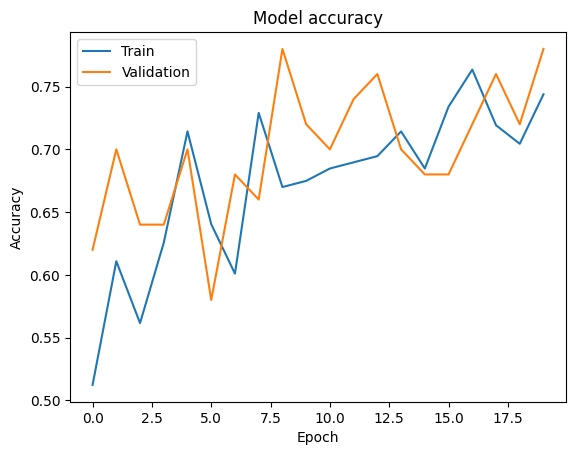

In [19]:
import matplotlib.pyplot as plt

#Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

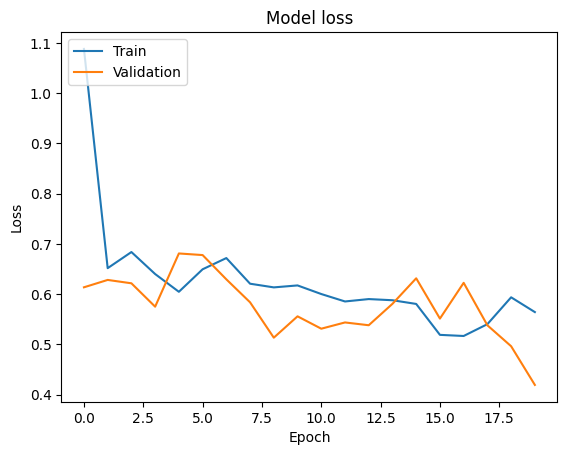

In [20]:
#Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Evaluate the model**


In [21]:
test_datagen = ImageDataGenerator()

test_data = test_datagen.flow_from_directory('/content/brain_tumor_dataset',
                                             target_size = (256, 256),
                                             batch_size = 32,
                                             class_mode = 'categorical')

test_loss, test_accuracy = model.evaluate(test_data)
print(f' Test accuracy : {test_accuracy}')

Found 253 images belonging to 2 classes.
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7965 - loss: 46.4413
 Test accuracy : 0.7944663763046265
